# Classification Models and Hyperparameter Finetuning

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier


### path and file

In [11]:
path = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\DATA"
path_result = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\result"

In [12]:
#importing model data
df_model=pd.read_csv(path_result+"/"+"model_after_feature_selection.csv", index_col=0)

### Split the data to tarin 80% and test 20% 

In [13]:
# Ensure the target column 'result' exists in the dataset
if 'result' in df_model.columns:
    # Define target
    y = df_model['result']
    
    # Define features by dropping the target column
    X = df_model.drop(columns=['result'])

    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Show the shapes of the resulting sets
    split_shapes = {
        "X_train": X_train.shape,
        "X_test": X_test.shape,
        "y_train": y_train.shape,
        "y_test": y_test.shape
    }
else:
    split_shapes = "❌ Column 'result' not found in dataset."

split_shapes


{'X_train': (10144, 26),
 'X_test': (2536, 26),
 'y_train': (10144,),
 'y_test': (2536,)}

### model run throw 8 calssification model  

In [14]:

# Classification metrics function
def classificationMetrics(y_true, y_pred, y_proba=None):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    result = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Precision': precision,
        'Recall': recall,
        'f1-score': f1
    }

    if y_proba is not None:
        try:
            result['Log-loss'] = metrics.log_loss(y_true, y_proba)
            result['AUC'] = metrics.roc_auc_score(y_true, y_proba, multi_class='ovr')
        except:
            result['Log-loss'] = None
            result['AUC'] = None
    else:
        result['Log-loss'] = None
        result['AUC'] = None

    return result


In [15]:
def get_feature_importance(model, feature_names):
    """
    Returns a sorted list of (feature_name, importance) tuples for a fitted model.
    
    Supports both tree-based models and linear models.
    """
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]  # for binary classification
        else:
            return None

        feature_importance = list(zip(feature_names, importances))
        return sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
    except Exception:
        return None


In [16]:


models_list = pd.DataFrame()
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ("SVM", SVC(probability=True)),
    ("Extra Trees", ExtraTreesClassifier())
]

# Store metrics and confusion matrices
models_list = pd.DataFrame()
confusion_matrices = {}
importance_feature={}
importance_rows = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = None

    # Metrics
    model_dict = {'Model': name}
    metrics_dict = classificationMetrics(y_test, y_pred, y_proba)
    row = pd.DataFrame([{**model_dict, **metrics_dict}])
    models_list = pd.concat([models_list, row], ignore_index=True)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    # importence features by model
    # Feature importance
    importance_feature[name] = get_feature_importance(model, X_train.columns)

models_list


,Model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
0,Logistic Regression,0.460174,0.407698,0.353141,0.267852,1.061479,0.530378
1,Decision Tree,0.380126,0.355576,0.355211,0.355374,22.342517,0.518125
2,Random Forest,0.444401,0.362274,0.360576,0.317730,1.065189,0.550976
3,AdaBoost,0.464905,0.301921,0.367119,0.299992,1.076144,0.548836
4,Gradient Boosting,0.475158,0.398793,0.383679,0.331317,1.046087,0.576487
5,XGBoost,0.455047,0.394152,0.394550,0.379794,1.101283,0.574945
6,SVM,0.450315,0.150105,0.333333,0.206997,1.059771,0.542073
7,Extra Trees,0.439274,0.362538,0.356825,0.316332,1.084086,0.541030


### confusion matrix for every model

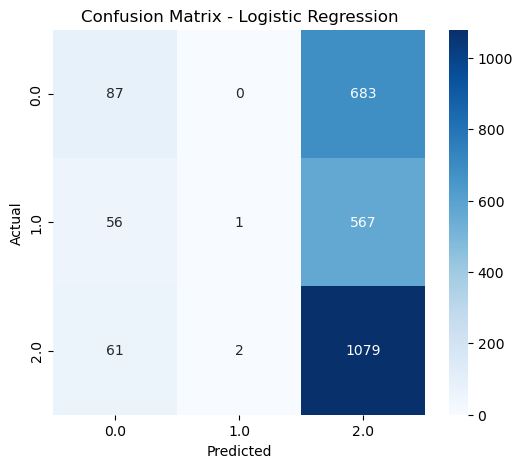

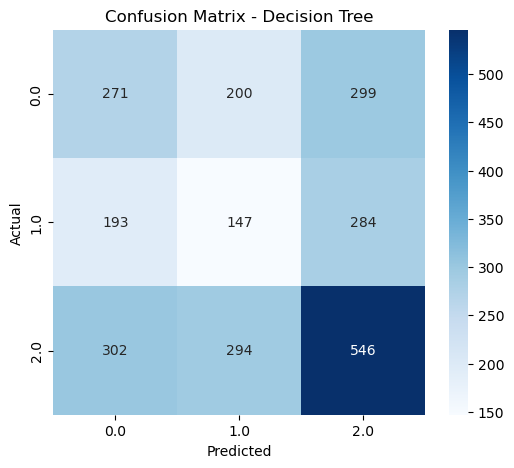

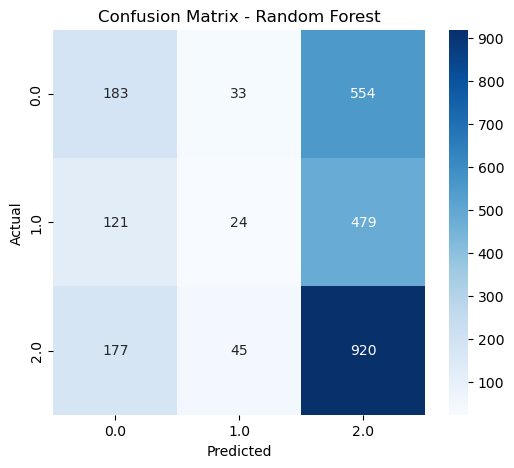

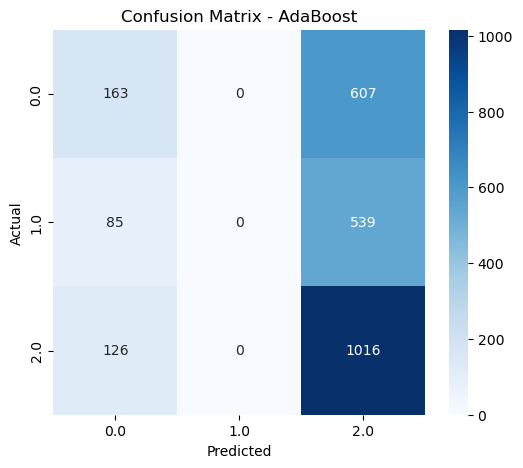

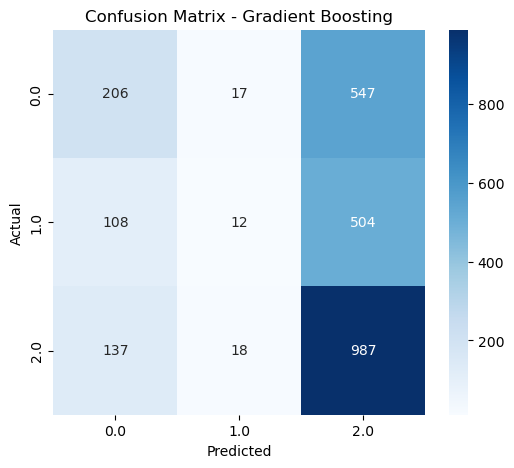

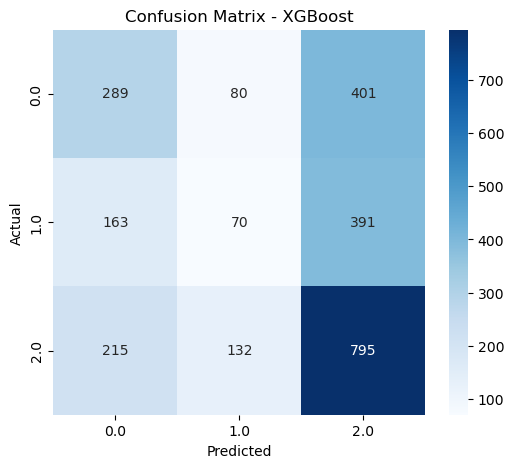

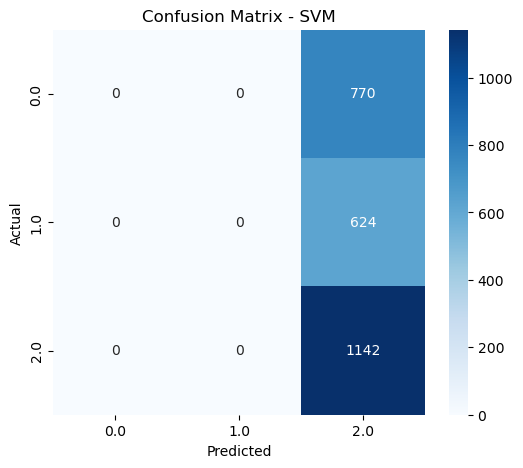

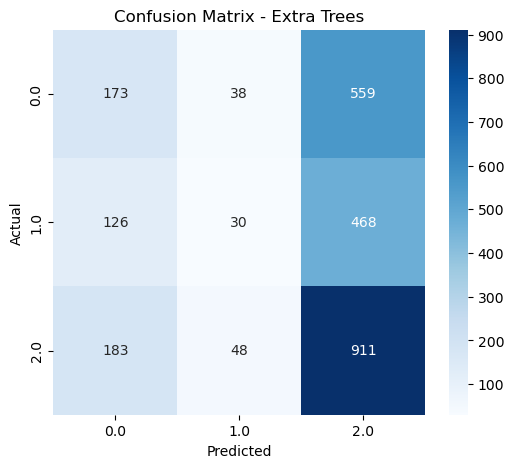

In [17]:
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
labels = sorted(y_test.unique())  # Get sorted class labels from your y_test

for model_name in models_list['Model']:
    conf_m = confusion_matrices.get(model_name)
    if conf_m is not None:
        plot_confusion_matrix(conf_m, labels, title=f"Confusion Matrix - {model_name}")
    else:
        print(f"No confusion matrix found for {model_name}")


In [18]:
importance_df = pd.DataFrame(importance_feature)
importance_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,SVM,Extra Trees
0,"(away_shotsOnTarget_h_rolling5, -0.03935788816...","(awayTeamID, 0.0637916196668232)","(homeTeamID, 0.05333154672735827)","(awayTeamID, 0.377966617181964)","(awayTeamID, 0.2252788626103085)","(awayTeamID, 0.061995808)",None,"(homeTeamID, 0.047514576117254646)"
1,"(away_total_saved_shots_h_rolling5, 0.03852074...","(away_ppda_h_rolling5, 0.05438331777897353)","(awayTeamID, 0.05198262992906776)","(homeTeamID, 0.36598283835472856)","(homeTeamID, 0.22066520707138282)","(homeTeamID, 0.060210664)",None,"(awayTeamID, 0.045859866644667284)"
2,"(home_shotsOnTarget_h_rolling5, -0.0330138703743)","(homeTeamID, 0.05436500832962972)","(away_ppda_h_rolling5, 0.048569880626369445)","(home_fouls_h_rolling5, 0.08461806372320956)","(home_ppda_a_rolling5, 0.04379205614267769)","(season, 0.03988041)",None,"(away_fouls_a_rolling5, 0.03995689925222295)"
3,"(home_total_assists_a_rolling5, 0.032236295038...","(home_ppda_a_rolling5, 0.05230308121527425)","(home_ppda_a_rolling5, 0.04836061551262184)","(home_ppda_h_rolling5, 0.03706204769467255)","(away_ppda_h_rolling5, 0.03893034415609497)","(home_ppda_h_rolling5, 0.03886967)",None,"(home_fouls_h_rolling5, 0.03957210237231033)"
4,"(away_total_saved_shots_a_rolling5, -0.0242208...","(home_fouls_h_rolling5, 0.04931574300511182)","(home_ppda_h_rolling5, 0.04788820574451808)","(away_ppda_h_rolling5, 0.03259126462270193)","(home_ppda_h_rolling5, 0.03845855815359171)","(away_ppda_h_rolling5, 0.03849973)",None,"(home_fouls_a_rolling5, 0.03945642239004816)"
5,"(away_deep_a_rolling5, 0.020774544745768158)","(home_ppda_h_rolling5, 0.047731715845193014)","(home_fouls_h_rolling5, 0.043435576974894766)","(home_total_assists_a_rolling5, 0.026527515014...","(home_deep_h_rolling5, 0.03631775767779371)","(home_ppda_a_rolling5, 0.038389046)",None,"(away_deep_h_rolling5, 0.039386694830050244)"
6,"(away_total_key_passes_a_rolling5, -0.02000571...","(home_shots_a_rolling5, 0.046149459400748855)","(away_fouls_h_rolling5, 0.042061081275568124)","(home_ppda_a_rolling5, 0.022906738425513495)","(home_fouls_a_rolling5, 0.030135005324224768)","(away_shotsOnTarget_h_rolling5, 0.03822348)",None,"(away_total_saved_shots_h_rolling5, 0.03936234..."
7,"(home_corners_h_rolling5, -0.019966690315279045)","(home_corners_h_rolling5, 0.04117817130270641)","(home_fouls_a_rolling5, 0.04162650823985515)","(home_fouls_a_rolling5, 0.0197371166390779)","(home_fouls_h_rolling5, 0.028736418368544524)","(home_shotsOnTarget_a_rolling5, 0.03775591)",None,"(away_total_saved_shots_a_rolling5, 0.03933125..."
8,"(home_shotsOnTarget_a_rolling5, 0.014242665775...","(away_total_key_passes_a_rolling5, 0.040972155...","(away_fouls_a_rolling5, 0.041173806902336685)","(away_deep_a_rolling5, 0.016504740884346704)","(away_fouls_h_rolling5, 0.02710278197327831)","(home_fouls_h_rolling5, 0.037612874)",None,"(home_ppda_a_rolling5, 0.03928189082273252)"
9,"(home_shots_h_rolling5, 0.014230968644229514)","(away_fouls_a_rolling5, 0.04070903933226438)","(away_total_key_passes_a_rolling5, 0.040591309...","(season, 0.01610305745931624)","(home_shots_a_rolling5, 0.026513007949772367)","(home_shotsOnTarget_h_rolling5, 0.03753318)",None,"(away_total_key_passes_a_rolling5, 0.039270797..."


## Gradient Boosting provides the best results with 47% accuracy

### Hyperparameter Finetuning

In [14]:
%pip install --upgrade xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 5]}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run it!
random_search.fit(X_train, y_train)

# Get the best model and performance
best_xgb = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("✅ Best Parameters:", best_params)
print("🎯 Best F1 Score (CV):", best_score)



Note: you may need to restart the kernel to use updated packages.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.7}
🎯 Best F1 Score (CV): 0.7876506378795641


### The best parameters result got lowe F1 score and accuracy then the defult result 

In [30]:
# Model list
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = [

    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),

]

# Store metrics and confusion matrices
models_list = pd.DataFrame()
confusion_matrices = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = None

    # Metrics
    model_dict = {'Model': name}
    metrics_dict = classificationMetrics(y_test, y_pred, y_proba)
    row = pd.DataFrame([{**model_dict, **metrics_dict}])
    models_list = pd.concat([models_list, row], ignore_index=True)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    importance = model.get_booster().get_score(importance_type='gain')
print(importance)



{'gameID': 0.9885990619659424, 'season': 0.974804162979126, 'homeTeamID': 0.9246196150779724, 'awayTeamID': 1.076666235923767, 'xGoals_h': 2.387289047241211, 'shots_h': 1.2246618270874023, 'shotsOnTarget_h': 3.4976184368133545, 'deep_h': 0.8823173642158508, 'ppda_h': 1.1634413003921509, 'fouls_h': 0.9191696643829346, 'corners_h': 1.085546851158142, 'total_key_passes_h': 1.8181782960891724, 'total_xGoalsChain_h': 1.3291221857070923, 'total_xGoalsBuildup_h': 1.1444073915481567, 'total_blocked_shots_h': 1.109259843826294, 'total_saved_shots_h': 3.3575353622436523, 'xGoals_a': 2.367873430252075, 'shots_a': 1.1281871795654297, 'shotsOnTarget_a': 3.580263376235962, 'deep_a': 1.014000415802002, 'ppda_a': 1.1671333312988281, 'fouls_a': 0.9169139862060547, 'total_key_passes_a': 1.5853379964828491, 'total_xGoalsChain_a': 1.3348984718322754, 'total_xGoalsBuildup_a': 1.03635835647583, 'total_saved_shots_a': 3.0661520957946777, 'game_year': 0.9808582067489624, 'game_month': 0.9297308325767517, 'gam

In [31]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Get importance dictionary (using 'gain')
importance_dict = model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display
print(importance_df)

                          Feature  Importance
0             total_assists_a_cat   20.896774
1             total_assists_h_cat   20.577375
2                 shotsOnTarget_a    3.580263
3                 shotsOnTarget_h    3.497618
4             total_saved_shots_h    3.357535
5             total_saved_shots_a    3.066152
6                        xGoals_h    2.387289
7                        xGoals_a    2.367873
8              total_key_passes_h    1.818178
9              total_key_passes_a    1.585338
10            total_xGoalsChain_a    1.334898
11            total_xGoalsChain_h    1.329122
12                        shots_h    1.224662
13                         ppda_a    1.167133
14                         ppda_h    1.163441
15          total_xGoalsBuildup_h    1.144407
16                        shots_a    1.128187
17          total_blocked_shots_h    1.109260
18                      corners_h    1.085547
19                     awayTeamID    1.076666
20              yellowCards_a_cat 

In [32]:
importance_df

,Feature,Importance
0,total_assists_a_cat,20.896774
1,total_assists_h_cat,20.577375
2,shotsOnTarget_a,3.580263
3,shotsOnTarget_h,3.497618
4,total_saved_shots_h,3.357535
5,total_saved_shots_a,3.066152
6,xGoals_h,2.387289
7,xGoals_a,2.367873
8,total_key_passes_h,1.818178
9,total_key_passes_a,1.585338
